In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ast import literal_eval

import capstone.portfolio.optimize as opt
from capstone.portfolio.metrics import Metrics
from capstone.portfolio.prune import prune_allocations
from capstone.portfolio.backtest import (
    backtest_portfolios, 
    get_transaction_costs, 
    reindex_costs
)

from capstone.utils import read_file, get_sectors
from tqdm.auto import tqdm

sns.set_style("whitegrid")
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["axes.edgecolor"] = "k"

In [2]:
df = read_file("master_df", index_col=0)
sectors = get_sectors()
snp_log_returns = read_file("snp_log_returns", index_col=0)
results = read_file("best_models_and_sectors", index_col=0)

results["AVAILABLE_STOCKS"] = results["AVAILABLE_STOCKS"].apply(lambda x: literal_eval(x))
results.head()

,SELECTED_MODEL,SELECTED_SECTOR,AVAILABLE_STOCKS
2007-11-20,SARIMAX,ENERGY,"[APA, BKR, CVX, COP, CTRA, DVN, EOG, EQT, XOM,..."
2008-05-22,SVR,CONSUMER_DISCRETIONARY,"[AMZN, AZO, BBWI, BBY, BKNG, BWA, KMX, CCL, CM..."
2008-11-19,SARIMAX,CONSUMER_DISCRETIONARY,"[AMZN, AZO, BBWI, BBY, BKNG, BWA, KMX, CCL, CM..."
2009-05-22,GradientBoost,REAL_ESTATE,"[ARE, AMT, AVB, BXP, CPT, CBRE, CCI, DLR, EQIX..."
2009-11-19,ElasticNet,REAL_ESTATE,"[ARE, AMT, AVB, BXP, CPT, CBRE, CCI, DLR, EQIX..."


In [3]:
# Define number of trading days in a year
trading_days = 252

# Set optimization lookback window (equal to forecast horizon)
lookback = int(trading_days / 2)

# Get unique available stocks from the results DataFrame
available_stocks = results.explode("AVAILABLE_STOCKS")['AVAILABLE_STOCKS'].unique()

# Create DataFrames to store allocations for different strategies
ms_allocations = pd.DataFrame(columns=available_stocks, index=results.index)
mv_allocations = pd.DataFrame(columns=available_stocks, index=results.index)
rp_allocations = pd.DataFrame(columns=available_stocks, index=results.index)

# Initialize columns for Sharpe ratios in the results DataFrame
results[["EW_SHARPE", "MS_SHARPE", "MV_SHARPE", "RP_SHARPE"]] = np.nan

# Loop through dates in the results index
for date in tqdm(results.index):

    # Get selected stocks for the current date
    selected_stocks = results.loc[date, "AVAILABLE_STOCKS"]

    # Retrieve past returns for selected stocks within the forecast window
    past_returns = snp_log_returns[selected_stocks].loc[:date][-lookback:]

    # Initialize equal-weighted portfolio weights
    weights = np.array([1/len(selected_stocks)] * len(selected_stocks))

    # Calculate and store the Equal-Weighted (EW) Sharpe ratio
    results.at[date, "EW_SHARPE"] = opt.port_sharpe(weights, past_returns)

    # Calculate the Maximum Sharpe (MS) and Minimum Variance (MV) portfolios
    ms_w, ms_s = opt.max_sharpe_opt(weights, past_returns)
    mv_w, mv_s = opt.min_var_opt(weights, past_returns)

    # Calculate and store the Risk Parity (RP) portfolio
    rp_w, rp_s = opt.risk_parity_opt(weights, past_returns)

    # Store allocations for each strategy
    ms_allocations.loc[date, selected_stocks] = ms_w
    mv_allocations.loc[date, selected_stocks] = mv_w
    rp_allocations.loc[date, selected_stocks] = rp_w

    # Store Sharpe ratios for MS, MV, and RP strategies
    results.loc[date, ["MS_SHARPE", "MV_SHARPE", "RP_SHARPE"]] = [ms_s, mv_s, rp_s]

# Drop the "AVAILABLE_STOCKS" column from the results DataFrame and display the first few rows
results.drop("AVAILABLE_STOCKS", axis=1).head()

  0%|          | 0/32 [00:00<?, ?it/s]

,SELECTED_MODEL,SELECTED_SECTOR,EW_SHARPE,MS_SHARPE,MV_SHARPE,RP_SHARPE
2007-11-20,SARIMAX,ENERGY,0.486888,1.778393,-0.130395,0.425154
2008-05-22,SVR,CONSUMER_DISCRETIONARY,-0.371399,1.631071,-0.329665,-0.415744
2008-11-19,SARIMAX,CONSUMER_DISCRETIONARY,-2.973604,0.031466,-1.020505,-2.853690
2009-05-22,GradientBoost,REAL_ESTATE,0.479045,1.756863,1.331186,0.598533
2009-11-19,ElasticNet,REAL_ESTATE,1.792080,3.182959,1.885873,1.902636


In [4]:
# Prune the allocation DataFrames (ms_allocations, mv_allocations, rp_allocations)
# by removing weights below a minimum weight threshold of 0.01 and re-normalizing the remaining weights.
ms_allocations, mv_allocations, rp_allocations = prune_allocations(
    ms_allocations, mv_allocations, rp_allocations, min_weight_th=0.01 
)

In [5]:
# Set a fixed transaction cost rate of 0.2%
transaction_costs = 0.002

# Calculate transaction costs for three different portfolio strategies: 
# Mean-Variance (mv), Risk Parity (rp), and Mean-Squared (ms).
# The get_transaction_costs function returns the transaction costs Series for each portfolio.
ms_costs, mv_costs, rp_costs = get_transaction_costs(
    ms_allocations, mv_allocations, rp_allocations, cost=transaction_costs
)

In [13]:
# Select constituent returns based on available stocks
constituent_returns = snp_log_returns[available_stocks]

# Backtest portfolios for MS, MV, and RP strategies using the specified allocations
ms_port_rets, mv_port_rets, rp_port_rets = backtest_portfolios(
    ms_allocations, 
    mv_allocations, 
    rp_allocations, 
    constituent_returns=constituent_returns
)

# Reindex costs to align with portfolio returns
ms_port_rets -= reindex_costs(ms_costs, ms_port_rets)
mv_port_rets -= reindex_costs(mv_costs, mv_port_rets)
rp_port_rets -= reindex_costs(rp_costs, rp_port_rets)

# Calculate the equal-weighted portfolio returns by taking the mean of constituent returns
ew_port_rets = constituent_returns.sum(axis=1) / len(constituent_returns.columns)

# Reindex the equal-weighted portfolio returns to match the other portfolio returns' index
ew_port_rets = ew_port_rets.reindex(ms_port_rets.index)

# Set the return at the earliest date to 0 for consistency
ew_port_rets.loc[ew_port_rets.index.min()] = 0

In [14]:
# Concatenate the portfolio returns (ew_port_rets, ms_port_rets, mv_port_rets, rp_port_rets) horizontally
port_rets = pd.concat([ew_port_rets, ms_port_rets, mv_port_rets, rp_port_rets], axis=1)

# Rename the columns to describe each portfolio strategy
port_rets.columns = ["ONE_OVER_N", "MAX_SHARPE", "MIN_VAR", "RISK_PARITY"]

# Create an instance of the Metrics class
portfolio_metrics = Metrics()

# Calculate portfolio metrics (e.g., mean return, volatility, Sharpe ratio) using the Metrics class
portfolio_metrics.calculate(port_rets)

,Sharpe Ratio,Cumulative Return,Annualized Return,Annualized Volatility
MAX_SHARPE,0.478672,2.357376,0.149336,0.311980
RISK_PARITY,0.349695,1.510000,0.095656,0.273541
ONE_OVER_N,0.403531,1.458024,0.092364,0.228888
MIN_VAR,0.345831,1.184227,0.075019,0.216923


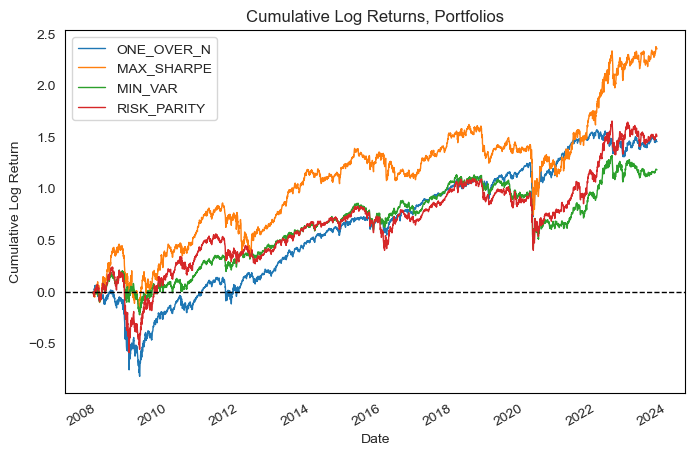

In [8]:
# Plot cumulative returns of each portfolio
port_rets.cumsum().plot(figsize=(8, (8*(2/3))), grid=False)
plt.axhline(0, linewidth=1, color="k", linestyle="--")
plt.title("Cumulative Log Returns, Portfolios")
plt.ylabel("Cumulative Log Return")
plt.show()

In [9]:
# Compare the best portfolio with sector returns
sector_metrics = Metrics()

best_portfolio = portfolio_metrics.metrics['Cumulative Return'].idxmax()
sector_returns_reindexed = df[sectors].reindex(port_rets.index).copy()
sector_returns_reindexed.loc[sector_returns_reindexed.index.min()] = 0
sector_comparison = pd.concat([port_rets[best_portfolio], sector_returns_reindexed], axis=1)
sector_metrics.calculate(sector_comparison)[:5]

,Sharpe Ratio,Cumulative Return,Annualized Return,Annualized Volatility
MAX_SHARPE,0.478672,2.357376,0.149336,0.311980
INFORMATION_TECHNOLOGY,0.499812,2.039880,0.129223,0.258544
HEALTH_CARE,0.567355,1.766901,0.111930,0.197285
INDUSTRIALS,0.464853,1.755934,0.111236,0.239292
CONSUMER_DISCRETIONARY,0.415844,1.695079,0.107381,0.258224


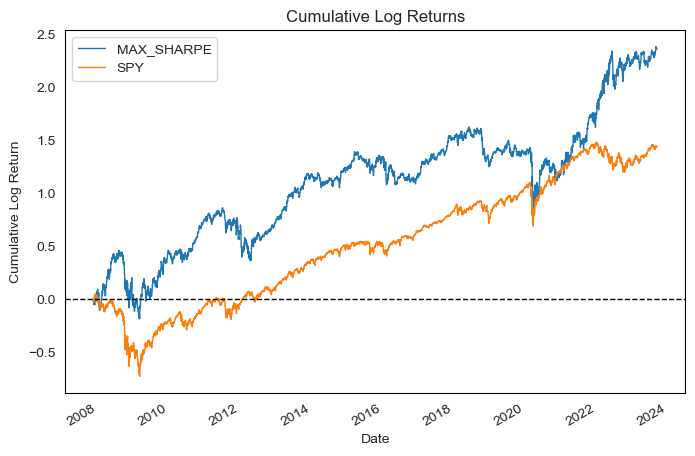

In [10]:
# Compare best portfolio to S&P 500
SPY_metrics = Metrics()

# Load SPY prices
SPY_log_rets = read_file("spy_log_returns", "data", index_col="Date")
SPY_log_rets.columns = ["SPY"]

# Combine SPY returns and best portfolo returns into a dataframe for comparison
spy_comparison = pd.concat([port_rets[best_portfolio], SPY_log_rets], axis=1)
spy_comparison.cumsum().plot(figsize=(8, (8*(2/3))), grid=False)
plt.axhline(0, linewidth=1, color="k", linestyle="--")
plt.title("Cumulative Log Returns")
plt.ylabel("Cumulative Log Return")
plt.show()

In [11]:
# Inspect portfolio metrics against SPY
SPY_metrics.calculate(spy_comparison)

,Sharpe Ratio,Cumulative Return,Annualized Return,Annualized Volatility
MAX_SHARPE,0.478672,2.357376,0.149336,0.31198
SPY,0.444477,1.438849,0.091149,0.20507
